## Multilabel with Segmentation U-Net, FCN & Mask RCNN

In [1]:
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import keras as K
import matplotlib.cm as cm
from tqdm import tqdm
from pathlib import Path
from keras import backend as K
from sklearn.model_selection import train_test_split
from PIL import Image
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.losses import binary_crossentropy
from tensorflow import keras
from keras.callbacks import TensorBoard
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

# Prepare Dataset

In [2]:
df = pd.read_csv('data/label.csv')
df

,Filename,Label
0,image_1.jpg,"[Kerbau,Manusia]"
1,image_10.jpg,"[Kerbau,Manusia]"
2,image_100.jpg,[Kerbau]
3,image_101.jpg,"[Kerbau,Manusia]"
4,image_102.jpg,"[Kerbau,Manusia]"
...,...,...
2110,image_1999.jpg,"[Kerbau,Manusia,Truk]"
2111,image_2.jpg,"[Kerbau,Manusia]"
2112,image_20.jpg,"[Kerbau,Manusia]"
2113,image_200.jpg,[Kerbau]


In [3]:
# buat daftar unique dari semua label
unique_label = set()
for label in df["Label"]:
    label_list = label.strip("[]").split(",")
    for label in label_list:
        unique_label.add(label.strip())
        
# buatkan kolom one-hot encodinf setiap label
for label in unique_label:
    df[label] = df["Label"].apply(lambda x: int(label in x))

In [4]:
df.head()

,Filename,Label,Truk,Manusia,Hewan liar,Motor,Kerbau
0,image_1.jpg,"[Kerbau,Manusia]",0,1,0,0,1
1,image_10.jpg,"[Kerbau,Manusia]",0,1,0,0,1
2,image_100.jpg,[Kerbau],0,0,0,0,1
3,image_101.jpg,"[Kerbau,Manusia]",0,1,0,0,1
4,image_102.jpg,"[Kerbau,Manusia]",0,1,0,0,1


In [5]:
df["Filename"] = "data/image/" + df["Filename"] 

<Axes: xlabel='Label'>

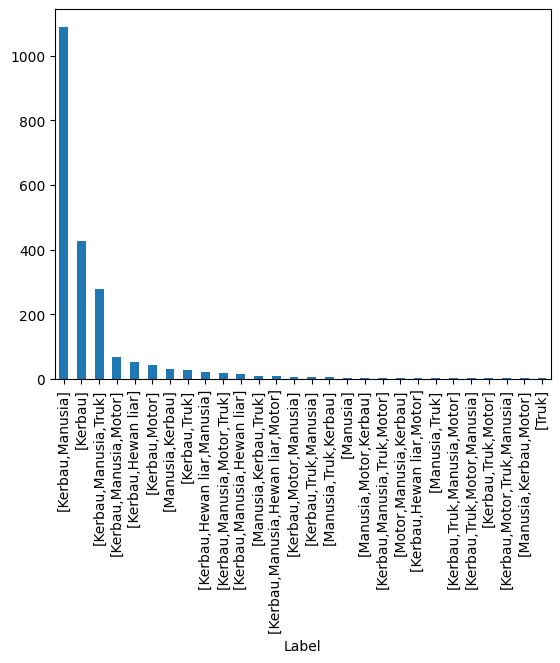

In [6]:
df['Label'].value_counts().plot(kind='bar')

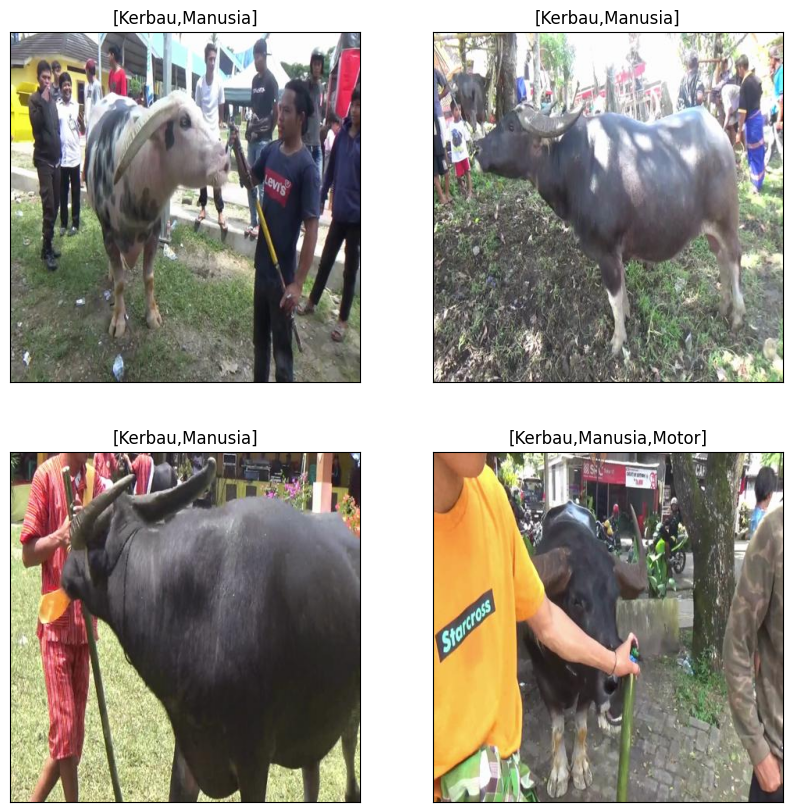

In [7]:
random_index = np.random.randint(0, len(df), 10)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10),
                    subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.Filename[random_index[i]]))
    ax.set_title(df.Label[random_index[i]])
plt.show()

In [ ]:
# df.drop(columns='Label', axis=1, inplace=True)
# df

In [8]:
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [9]:
train = train.drop(columns="Label", axis=1)
train

,Filename,Truk,Manusia,Hewan liar,Motor,Kerbau
2072,data/image/image_1964.jpg,0,1,0,0,1
1549,data/image/image_1490.jpg,0,1,0,1,1
73,data/image/image_165.jpg,0,0,0,0,1
596,data/image/image_587.jpg,0,1,0,0,1
1107,data/image/image_1092.jpg,1,1,0,0,1
...,...,...,...,...,...,...
1638,data/image/image_1570.jpg,0,1,0,1,1
1095,data/image/image_1081.jpg,1,1,0,0,1
1130,data/image/image_1112.jpg,0,1,0,0,1
1294,data/image/image_1260.jpg,1,1,0,0,1


In [10]:
test = test.drop(columns="Label", axis=1)
test

,Filename,Truk,Manusia,Hewan liar,Motor,Kerbau
1617,data/image/image_1551.jpg,0,1,0,0,1
1471,data/image/image_142.jpg,0,1,0,0,1
259,data/image/image_332.jpg,0,1,0,0,1
432,data/image/image_489.jpg,0,0,0,0,1
1506,data/image/image_1451.jpg,0,1,0,0,1
...,...,...,...,...,...,...
861,data/image/image_855.jpg,0,0,0,0,1
634,data/image/image_625.jpg,0,1,0,0,1
59,data/image/image_152.jpg,0,0,0,0,1
411,data/image/image_47.jpg,0,1,1,0,1


In [11]:
classes = ["Truk",	"Manusia",	"Hewan liar",	"Motor",	"Kerbau"]

In [12]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
# The value for class_mode in flow_from_dataframe MUST be 'raw' if you are attempting to do multilabel classification.
train_gen = train_datagen.flow_from_dataframe(train, 
                                              x_col='Filename', 
                                              y_col=classes,
                                              target_size=(224,224),
                                              class_mode='raw',
                                              batch_size=32,
                                              shuffle=True,
                                              subset='training')
val_gen = train_datagen.flow_from_dataframe(train,
                                          x_col='Filename',
                                          y_col=classes,
                                          target_size=(224,224),
                                          class_mode='raw',
                                          batch_size=16,
                                          subset='validation')
test_gen = test_datagen.flow_from_dataframe(test,
                                            x_col='Filename',
                                            # y_col="Label",
                                            target_size=(224,224),
                                            class_mode=None)

Found 1354 validated image filenames.
Found 338 validated image filenames.
Found 423 validated image filenames.


## Metrics

In [13]:
# recall
def recall_m(y_true, y_pred):
    true_positif = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positif = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positif / (possible_positif + K.epsilon())
    return recall
# precission
def precission_m(y_true, y_pred):
    true_positif = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positif = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precission = true_positif / (predicted_positif + K.epsilon())
    return precission

# f1-score
def f1_m(y_true, y_pred):
    recall = recall_m(y_true, y_pred)
    precission = precission_m(y_true, y_pred)
    f1 = 2*((precission * recall) / (precission + recall + K.epsilon()))
    return f1

metrics = ["accuracy", recall_m, precission_m, f1_m]

## Callback

In [14]:
import datetime
def tensorboard_callback(name):
    logdir = os.path.join("Tensorboard/logs", datetime.datetime.now().strftime(f"%Y-%m-%d-{name}"))
    return TensorBoard(logdir)

class myCallback(tf.keras.callbacks.Callback):
    def __init__(self, accuracy=0.9):
        self.accuracy = accuracy
        
    def on_epoch_end(self, epoch, logs=None):
        if logs.get("val_accuracy") > self.accuracy:
            print(f"\nAkurasi telah mencapai {self.accuracy}%")
            self.model.stop_training = True

# Plot Model

In [15]:
def plot_model(model, name_model):
        fig, (ax1, ax2) = plt.subplots(nrows=2,
                                     ncols=1,
                                     figsize=(15, 15))
        ax1.plot(model.history["accuracy"], marker=".")
        ax1.plot(model.history["recall_m"], marker=".") 
        ax1.plot(model.history["precission_m"], marker=".")
        ax1.plot(model.history["f1_m"], marker=".")
        ax1.set_xlabel("epochs")
        ax1.legend(["accuracy", 
        "recall", 
        "precission", 
        "f1"], loc="lower left")
        ax1.grid(True)
        ax1.set_title(name_model + ' training')
        
        ax2.plot(model.history["val_accuracy"], marker=".")
        ax2.plot(model.history["val_recall_m"], marker=".") 
        ax2.plot(model.history["val_precission_m"], marker=".")
        ax2.plot(model.history["val_f1_m"], marker=".")
        ax2.set_xlabel("epochs")
        ax2.legend(["val_accuracy", 
                "val_recall", 
                "val_precission", 
                "val_f1"], loc="lower left")
        ax2.grid(True)
        ax2.set_title(name_model + " val")
        
        fig.suptitle(name_model, fontsize=24)
        return plt.show

# U-Net

Berikut arsitektur keseluruhan U-Net yang akan digunakan:

<img src='https://drive.google.com/uc?export=view&id=1BeQSKL2Eq6Fw9iRXsN1hgunY-CS2nH7V' alt='unet'>

UNet terdiri dari encoder (downsampler) dan decoder (upsampler) dengan hambatan di antaranya. Panah abu-abu sesuai dengan koneksi lompatan yang menggabungkan output blok encoder ke setiap tahap decoder.

### Encoder
Block-block encoder berisi 2 layer Conv2D diakttifkan oleh relu, serta di ikuti oleh MaxpPooling dan Dropout

In [ ]:
def conv2d_block(input_tensor, n_filter, kernel_size=3):
    ''' 
    Arg:
    input_tensor (tensor) - tensor masukan
    n_filter (int) - jumlah filter
    kernel_size (int) -- ukuran kernel untuk konvolusi

    return
    tensor dari fitur keluaran
    '''
    x = input_tensor
    for i in range(2):
        x = tf.keras.layers.Conv2D(filters=n_filter, kernel_size=(kernel_size, kernel_size),\
                                    kernel_initializer="he_normal",padding='same')(x)
        x = tf.keras.layers.Activation("relu")(x)
    return x

def encoder_block(inputs, n_filter=64, pool_size=2, dropout=0.3):
    '''
    Arg:
    input (tensor) - tensor masukan
    n_filter (int) - jumlah filter
    pool_size - ukuran pool size
    dropout - jumlah yang ingin di dropout/buang

    return
    f - fitur keluaran dari block conv
    p - fitur yang dikumpulkan di MaxPooling dengan DropOut
    '''
    f = conv2d_block(inputs, n_filter=n_filter)
    p = tf.keras.layers.MaxPooling2D(pool_size=(pool_size, pool_size))(f)
    p = tf.keras.layers.Dropout(dropout)(p)
    return f, p

def encoder(inputs):
    '''
    Arg:
    inputs - masukkan gambar

    return
    p4 - fitur yang dikumpulkan dari keseluruhan encoder block
    (f1, f2, f3, f4) - fitur yang dikeluarkan dari semua encoder block
    '''
    f1, p1 = encoder_block(inputs, n_filter=64, pool_size=2, dropout=0.3)
    f2, p2 = encoder_block(p1, n_filter=128, pool_size=2, dropout=0.3)
    f3, p3 = encoder_block(p2, n_filter=256, pool_size=2, dropout=0.3)
    f4, p4 = encoder_block(p3, n_filter=512, pool_size=2, dropout=0.3)
    return p4, (f1, f2, f3, f4)


### Bottleneck
Sebuah bottleneck mengikuti blok encoder dan digunakan untuk mengekstrak lebih banyak fitur. Ini tidak memiliki lapisan penyatuan sehingga dimensinya tetap sama.

In [ ]:
def bottleneck(inputs):

    x = conv2d_block(inputs, n_filter=1024)
    return x

### Decoder
 decoder yang meng-upsampling fitur kembali ke ukuran gambar asli. Pada setiap tingkat upsampling, akan mengambil output dari blok encoder yang sesuai dan menggabungkannya sebelum memasukkannya ke blok decoder berikutnya

In [ ]:
def decoder_block(inputs, conv_output, n_filter=64, kernel_size=3, strides=2, dropout=0.3):
    '''
    Arg:
    inputs (tensor) - kumpulan fitur input
    conv_output (tensor) - fitur dari blok encoder
    n_filter (int) -- jumlah filter
    kernel_size (int) -- ukuran kernel
    strides (int) -- langkah untuk dekonvolusi/upsampling
    padding (string) - "sama" atau "valid", memberi tahu apakah bentuk akan dipertahankan dengan padding nol

    return
    c (tensor) - fitur keluaran dari blok decoder
    '''
    u = tf.keras.layers.Conv2DTranspose(n_filter, kernel_size, strides=strides, padding='same')(inputs)
    c = tf.keras.layers.concatenate([u, conv_output])
    c = tf.keras.layers.Dropout(dropout)(c)
    c = conv2d_block(c, n_filter, kernel_size=3)

    return c

def decoder(input, convs, output_channels):
    '''
    Arg:
    inputs (tensor) - kumpulan fitur input
    convs (tuple) -- fitur dari blok penyandi
    output_channels (int) -- jumlah kelas dalam peta label
    activation (softmax/sigmoid,etc) - aktifasi yang dipakai

    return
    output (tensor) -- peta label berdasarkan piksel dari gambar
    '''
    f1, f2, f3, f4 = convs

    c6 = decoder_block(input, f4, n_filter=512, kernel_size=(3,3), strides=(2,2), dropout=0.3)
    c7 = decoder_block(c6, f3, n_filter=256, kernel_size=(3,3), strides=(2,2), dropout=0.3)
    c8 = decoder_block(c7, f2, n_filter=128, kernel_size=(3,3), strides=(2,2), dropout=0.3)
    c9 = decoder_block(c8, f1, n_filter=64, kernel_size=(3,3), strides=(2,2), dropout=0.3)

    flatten = tf.keras.layers.Flatten()(c9)
    output =  tf.keras.layers.Dense(output_channels, activation='sigmoid')(flatten)
    return output


In [ ]:
def unet(input_shape):
    '''
    Mendefinisikan UNet dengan menghubungkan encoder, bottleneck, dan decoder.

    args:
    input_shape (int)- besaran deminsi input
    output (int) - jumlah output yang dikeluarkna
    activation - aktifasi yang digunakan untuk klasifikasi
    '''

    input = tf.keras.layers.Input(shape=input_shape)
    encoder_output, convs = encoder(input)
    bottlenecks = bottleneck(encoder_output)
    outputs = decoder(bottlenecks, convs, output_channels=5)

    model = tf.keras.Model(inputs=input, outputs=outputs)
    return model

In [ ]:
model_uNet = unet(input_shape=(224, 224, 3,))
model_uNet.compile(optimizer='adam', loss="binary_crossentropy",
                   metrics=metrics)

In [ ]:
model_uNet.summary()

In [ ]:
%load_ext tensorboard

In [ ]:
with tf.device("/device:GPU:0"):
    history1 = model_uNet.fit(train_gen,
                              steps_per_epoch=train_gen.n // train_gen.batch_size,
                              epochs=50,
                              validation_data=val_gen,
                              validation_steps=val_gen.n // val_gen.batch_size,
                              callbacks=[tensorboard_callback("uNet"),
                              myCallback(accuracy=0.95)])

In [ ]:
model_uNet.evaluate(test_gen)

## Model Common

In [ ]:
def model_common():
    inputs = tf.keras.layers.Input(shape=(224, 224, 3))
    x = conv2d_block(input_tensor=inputs, n_filter=64)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = conv2d_block(input_tensor=x, n_filter=128)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = conv2d_block(input_tensor=x, n_filter=128)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = conv2d_block(input_tensor=x, n_filter=256)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = conv2d_block(input_tensor=x, n_filter=512)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    output = tf.keras.layers.Dense(5, activation="sigmoid")(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=output)
    return model
model_common = model_common()

In [ ]:
model_common.summary()

In [ ]:
history2 = model_common.fit(train_gen,
                              steps_per_epoch=train_gen.n // train_gen.batch_size,
                              epochs=50,
                              validation_data=val_gen,
                              validation_steps=val_gen.n // val_gen.batch_size,
                              callbacks=[tensorboard_callback("common"),
                              myCallback(accuracy=0.9)])

In [ ]:
model_common.evaluate(test_gen)

## Model CNN + BiLSTM

In [16]:

def conv2d(input_tensor, filter, karnel_size=5):
    x = input_tensor
    for i in range(3):
        x = tf.keras.layers.Conv2D(filter, 
                                   (karnel_size, karnel_size),
                                   activation="relu",
                                   kernel_initializer="he_normal",
                                   padding="same")(x)
        x = tf.keras.layers.MaxPooling2D((2, 2))(x)
        return x

In [18]:
def model_cnn_lstm():
    input = tf.keras.layers.Input(shape=(224, 224, 3), name="input")
    # first componen
    x = tf.keras.layers.Conv2D(32, (5, 5),
                               activation="relu",
                               kernel_initializer="he_normal",
                               padding="same")
    x = conv2d(input_tensor=input, filter=32, karnel_size=3)
    # second componen
    x = conv2d(input_tensor=x, filter=64, karnel_size=3)
    # three componen
    x = conv2d(input_tensor=x, filter=128, karnel_size=3)
    
    # x=keras.layers.MaxPooling2D((2, 2), name="pool1")(x)
    # Kami telah menggunakan dua lapisan max pool dengan ukuran dan langkah 2.
    # Oleh karena itu, peta fitur yang telah di-downsample menjadi 4 kali lebih kecil. 
    # Jumlah filter pada lapisan terakhir adalah 64. Ubah bentuknya sesuai sebelum
    # meneruskan keluaran ke bagian RNN dari model.
    new_shape = ((224 // 8), (224 // 8) * 128)
    x = tf.keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True, dropout=0.2))(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True, dropout=0.2))(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    output = tf.keras.layers.Dense(5, activation="sigmoid")(x)
    
    model = tf.keras.Model(inputs=[input], outputs=[output])
    return model

In [19]:
cnn_lstm = model_cnn_lstm()

In [20]:
cnn_lstm.compile(optimizer='adam', loss="binary_crossentropy",
                   metrics=metrics)

In [21]:
cnn_lstm.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 56, 56, 128)       73856 

In [22]:
with tf.device("/device:GPU:0"):
    history3 = cnn_lstm.fit(train_gen,
                              steps_per_epoch=train_gen.n // train_gen.batch_size,
                              epochs=100,
                              validation_data=val_gen,
                              validation_steps=val_gen.n // val_gen.batch_size,
                              callbacks=[tensorboard_callback("cnn_lstm"),
                              myCallback(accuracy=0.95)])

Epoch 1/100
42/42 [==============================] - 14s 108ms/step - loss: 0.3748 - accuracy: 0.2179 - recall_m: 0.8182 - precission_m: 0.8350 - f1_m: 0.8239 - val_loss: 0.3186 - val_accuracy: 0.1845 - val_recall_m: 0.8494 - val_precission_m: 0.8646 - val_f1_m: 0.8560
Epoch 2/100
42/42 [==============================] - 3s 66ms/step - loss: 0.3027 - accuracy: 0.2103 - recall_m: 0.8581 - precission_m: 0.8770 - f1_m: 0.8664 - val_loss: 0.3150 - val_accuracy: 0.1845 - val_recall_m: 0.8530 - val_precission_m: 0.8661 - val_f1_m: 0.8576
Epoch 3/100
42/42 [==============================] - 3s 66ms/step - loss: 0.2942 - accuracy: 0.2095 - recall_m: 0.8674 - precission_m: 0.8710 - f1_m: 0.8681 - val_loss: 0.3166 - val_accuracy: 0.1845 - val_recall_m: 0.8515 - val_precission_m: 0.8646 - val_f1_m: 0.8567
Epoch 4/100
42/42 [==============================] - 3s 67ms/step - loss: 0.2949 - accuracy: 0.2118 - recall_m: 0.8700 - precission_m: 0.8708 - f1_m: 0.8695 - val_loss: 0.3174 - val_accuracy: 0.

<function matplotlib.pyplot.show(close=None, block=None)>

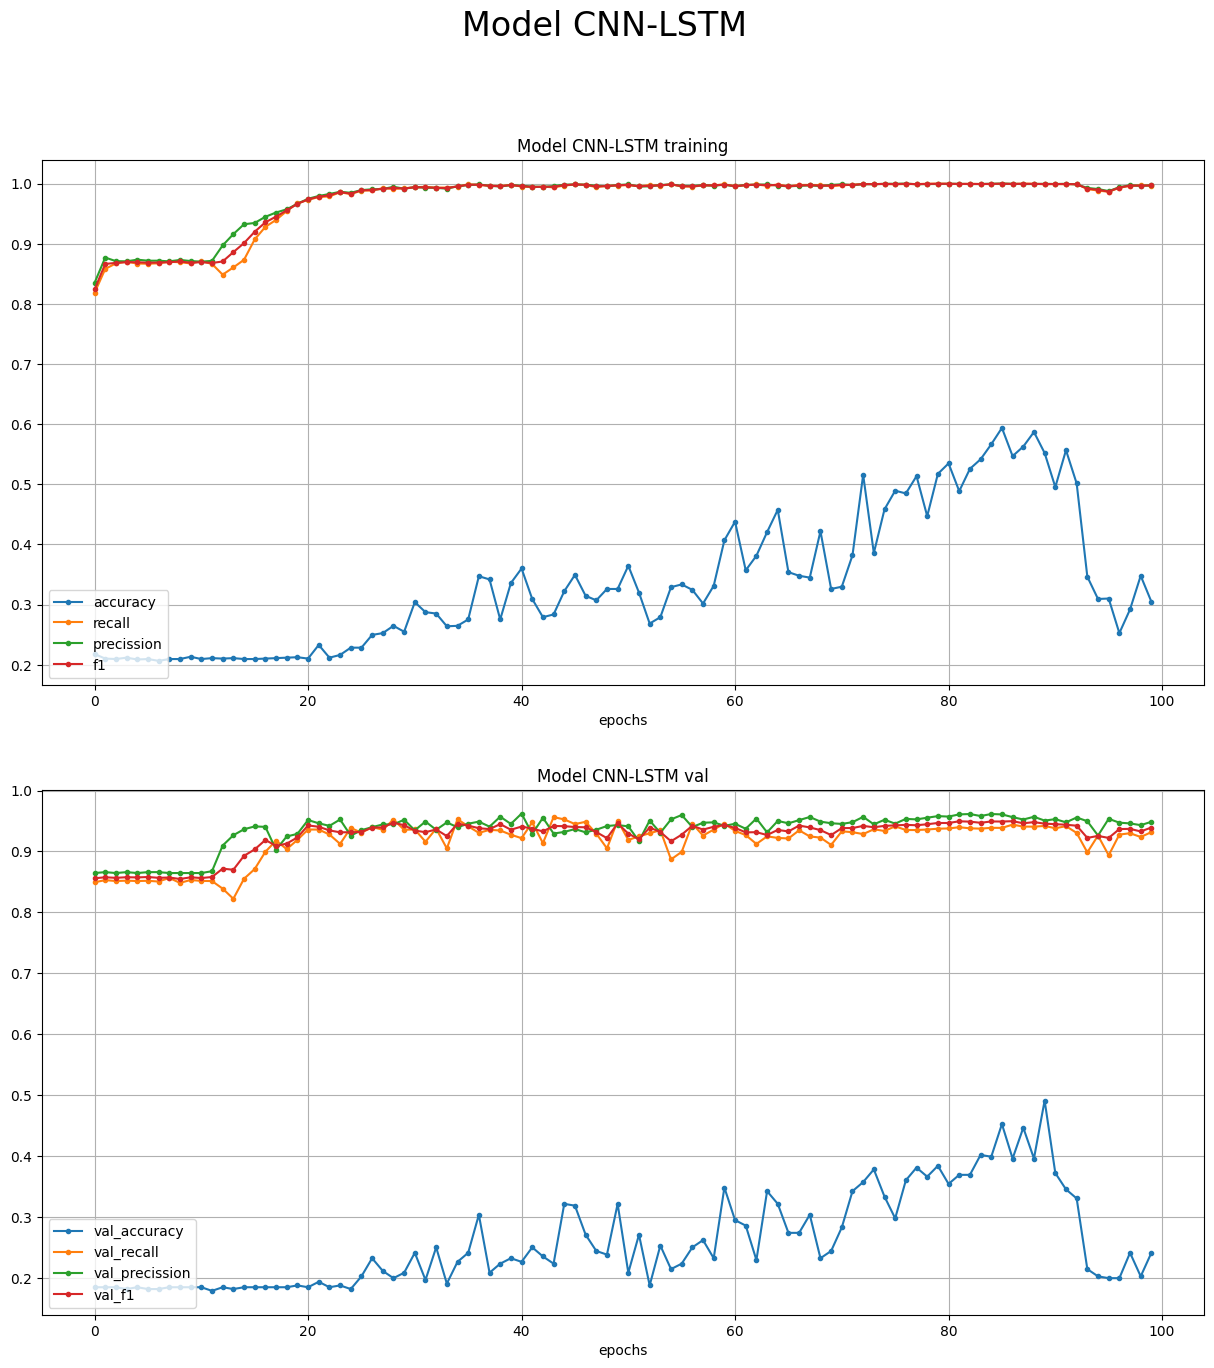

In [23]:
plot_model(history3, "Model CNN-LSTM")

# Define Vis Model

In [ ]:
def layer_name(model):
    outputs = [layer.outputs for layer in model.layer]
    layer_name = []
    for layer in outputs:
        layer_name.append(layer.name.split("/"))
    
    return layer_name

In [ ]:
def visualize_intermediate_activations(layer_names, activations):
    assert len(layer_names)==len(activations), "Make sure layers and activation values match"
    images_per_row=16
    
    for layer_name, layer_activation in zip(layer_names, activations):
        nb_features = layer_activation.shape[-1]
        size= layer_activation.shape[1]

        nb_cols = nb_features // images_per_row
        grid = np.zeros((size*nb_cols, size*images_per_row))

        for col in range(nb_cols):
            for row in range(images_per_row):
                feature_map = layer_activation[0,:,:,col*images_per_row + row]
                feature_map -= feature_map.mean()
                feature_map /= feature_map.std()
                feature_map *=255
                feature_map = np.clip(feature_map, 0, 255).astype(np.uint8)

                grid[col*size:(col+1)*size, row*size:(row+1)*size] = feature_map

        scale = 1./size
        plt.figure(figsize=(scale*grid.shape[1], scale*grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.axis('off')
        plt.imshow(grid, aspect='auto', cmap='viridis')
    plt.show()

### Define Grad Cam

In [ ]:
def get_img_array(dir, size):
    img = keras.utils.load_img(dir, target_size=size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array)
    return array
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [ ]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))